# Predicting online shoppers’ purchasing intention
## Classification using SHAP for feature interpretation and selection
### Random Forest

---

Data source:
https://archive.ics.uci.edu/ml/datasets/Online+Shoppers+Purchasing+Intention+Dataset

SHAP:
https://shap.readthedocs.io/en/latest/index.html


In [ ]:
# download from github
%%capture
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/X_train.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_test.npy;
!wget https://github.com/EricaXia/dsci_552_project/raw/main/data/y_train.npy;

## to view curr directory
# !ls
!pip install shap


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pprint
import warnings
from collections import Counter

# data preprocessing
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline, TransformerMixin
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.neighbors import LocalOutlierFactor
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV

# classification models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import (
    RandomForestClassifier
    AdaBoostClassifier
)

# metrics
from sklearn.metrics import accuracy_score, auc, roc_auc_score, classification_report

import shap
shap.initjs()

In [ ]:
import shap
shap.initjs()

In [ ]:
feature_names2 = ['Administrative',
 'Administrative_Duration',
 'Informational',
 'Informational_Duration',
 'ProductRelated',
 'ProductRelated_Duration',
 'BounceRates',
 'ExitRates',
 'PageValues',
 'SpecialDay',
 'Month_Aug',
 'Month_Dec',
 'Month_Feb',
 'Month_Jul',
 'Month_June',
 'Month_Mar',
 'Month_May',
 'Month_Nov',
 'Month_Oct',
 'Month_Sep',
 'VisitorType_New_Visitor',
 'VisitorType_Other',
 'VisitorType_Returning_Visitor',
 'Weekend_True',
 'OperatingSystems',
 'Browser',
 'Region',
 'TrafficType']

print(len(feature_names2))

28


In [ ]:
## Load arrays to reload for later use
## Load cleaned data arrays
with open('X_train.npy', 'rb') as f:
    X_train = np.load(f)
with open('X_test.npy', 'rb') as f:
    X_test = np.load(f)
with open('y_train.npy', 'rb') as f:
    y_train = np.load(f)
with open('y_test.npy', 'rb') as f:
    y_test = np.load(f)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(13972, 28) (4069, 28) (13972,) (4069,)


In [ ]:
X_train = pd.DataFrame(X_train, columns=feature_names2)
X_test = pd.DataFrame(X_test, columns=feature_names2)


# Tuning Hyperparameters

### Random Forest Classifier (Tuning HPs)
with randomized grid search for tuning hyperparameters and finding optimal model

In [ ]:
rfc = RandomForestClassifier()
# what possible params to tune
pprint.pprint(rfc.get_params())

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}


In [ ]:
# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

# Random search of parameters, using cross validation, use all cores
rf_rand = RandomizedSearchCV(estimator=rfc, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)

In [ ]:
# Fit the random search model
rf_rand.fit(X_train, y_train)

Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.8min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 38.4min finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    max_samples=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
               

In [ ]:
# print results of rand grid search - model before shap
best_params = rf_rand.best_params_
pprint.pprint(best_params)

{'max_features': 'sqrt',
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'n_estimators': 1400}


In [ ]:
## Random Forest new (optimized from results of grid search)

# best_params = {'max_features': 'sqrt',
#  'min_samples_leaf': 1,
#  'min_samples_split': 2,
#  'n_estimators': 1400}

rfc = RandomForestClassifier(**best_params)

rfc.fit(X_train,y_train)  # fit the model to the training data

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=1400,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [ ]:
## Get CV score
score = cross_val_score(rfc, X_train, y_train)
print(np.round(score.mean(), 4))

0.9197


In [ ]:
## Calc Prec, Recall, F1 scores on test set

y_pred = rfc.predict(X_test)  # predict on test set
target_names = ['0: No Revenue', '1: Revenue']
report1 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
print(report1)
report1_df = pd.DataFrame(report1).transpose()
model_name = "RandomForestClassifier"
report1_df.to_csv(f"{model_name}_report1.csv", index=False)
# files.download(f"{model_name}_report1.csv")

{'0: No Revenue': {'precision': 0.9489336136978072, 'recall': 0.9193830034924331, 'f1-score': 0.9339246119733925, 'support': 3436}, '1: Revenue': {'precision': 0.6256756756756757, 'recall': 0.731437598736177, 'f1-score': 0.674435542607429, 'support': 633}, 'accuracy': 0.8901449987711969, 'macro avg': {'precision': 0.7873046446867414, 'recall': 0.825410301114305, 'f1-score': 0.8041800772904107, 'support': 4069}, 'weighted avg': {'precision': 0.8986455147132878, 'recall': 0.8901449987711969, 'f1-score': 0.8935568113077118, 'support': 4069}}


In [ ]:
print(round(roc_auc_score(y_test, rfc.predict_proba(X_test)[:,1]),4))

0.9244


## SHAP visuals 

To show feature contributions to the model output (magnitude, postiive or negative class, num of samples, ...)


Types of plots
* Force Plot
* Bar Plot
* Beeswarm Plot / Scatter Plot
* Waterfall Plot (for indiv preds)

In [ ]:
## Take smaller samples for visualization
X_train_sample = shap.utils.sample(X_train, nsamples=50, random_state=0)
X_test_sample = shap.utils.sample(X_test, nsamples=50, random_state=0)

## Kernel Explainer

In [ ]:
# explain predictions of model on test set
explainer = shap.KernelExplainer(rfc.predict_proba, X_train_sample)

# compute SHAP values
shap_values = explainer.shap_values(X_test_sample)

In [ ]:
# Force Plot
shap.force_plot(explainer.expected_value[0], shap_values[0], X_test_sample)

Force plot:
    
* The horizontal/X-axis at the top represents the sample number. We have 100 samples in this visual.
* The two colors represent the two class labels (default or no default)

## Tree Explainer

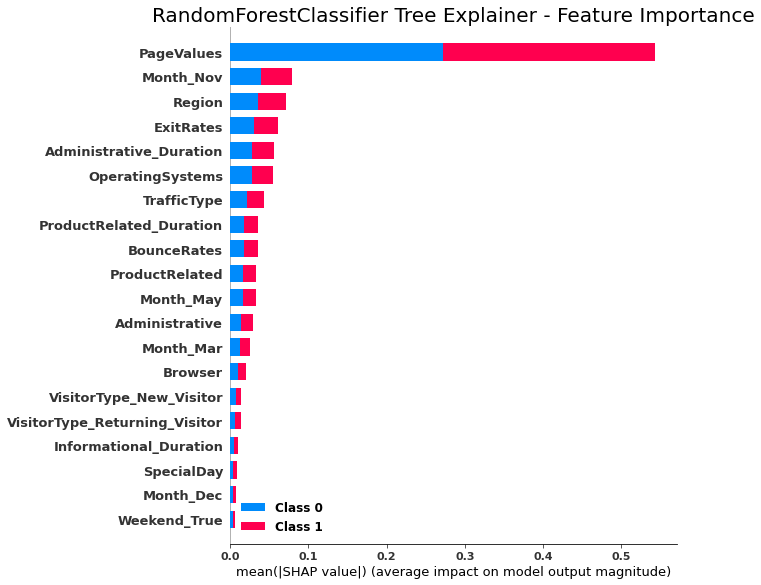

In [ ]:
## Bar Plot 
# explain all the predictions in the test set
explainer = shap.TreeExplainer(rfc)
shap_values = explainer.shap_values(X_test_sample)
plt.title(f"{model_name} Tree Explainer - Feature Importance")
shap.summary_plot(shap_values, (X_test_sample))

Bar Plot:

creates a global feature importance plot, where the global importance of each feature is taken to be the mean absolute value for that feature over all the given samples.

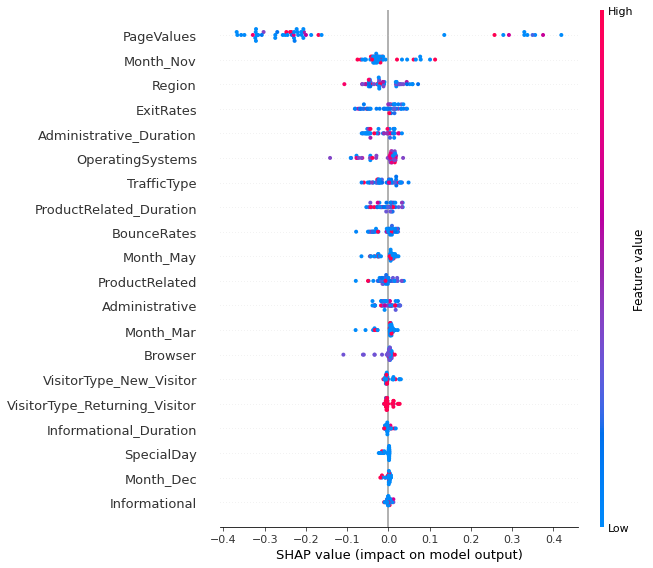

In [ ]:
# index [1] represents class label 1
shap.summary_plot(shap_values[1], X_train_sample)

In [ ]:
# Waterfall plot

plt.title(f"{model_name} Tree Explainer - First Observation Feature Importance")
shap.plots._waterfall.waterfall_legacy(explainer.expected_value[0], shap_values[0][0], X_train_sample.iloc[0])

shap_values is a list of 2 arrays, representing class labels 0 and 1.

Both arrays have 50 observations and 29 features.

# Modeling
## Get the most and least important features
### Compare top 10, top 15, top 20, top 25 features

In [ ]:
## Get mean of all training sample shap values

train_shap_avg = np.average(shap_values[0], axis=0)
# print(train_shap_avg.shape)
train_shap_avg_2 = []
for i, val in enumerate(list(train_shap_avg)):
  train_shap_avg_2.append((i, feature_names2[i], val))

sorted_shap = sorted(train_shap_avg_2, key=lambda x: x[2])

top_10 = sorted_shap[:10]
top_15 = sorted_shap[:15]
top_20 = sorted_shap[:20]
top_25 = sorted_shap[:25]

top_10_indices = [t[0] for t in top_10]
top_15_indices = [t[0] for t in top_15]
top_20_indices = [t[0] for t in top_20]
top_25_indices = [t[0] for t in top_25]

In [ ]:
## Function to compare top 10, top 15, top 20, top 25 features as selected by SHAP
## for model performance (based on CV score and test set scores)

model = RandomForestClassifier()

# specify parameters and distributions to sample from
param_dist = {
    "n_estimators": list(np.linspace(200, 1600, 8, dtype=int)),
    "max_features": ["auto", "sqrt"],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4]
}

def compare_models(list_of_indices, param_dist, model):
  clf_reports = []
  for top_n_indices in list_of_indices:
    to_keep =  top_n_indices
    print("Training for")
    print(to_keep)
    X_train_ss = X_train.iloc[:,to_keep]
    print(f"Top {X_train_ss.shape[1]} features")
    model_rand = RandomizedSearchCV(estimator=model, param_distributions=param_dist, n_iter=100, cv=3, verbose=2, random_state=0, n_jobs=-1)
    model_rand.fit(X_train_ss, y_train)
    best_params2 = model_rand.best_params_
    model_best = RandomForestClassifier(**best_params2)
    model_best.fit(X_train_ss, y_train)  # fit the model to the training data
    score = cross_val_score(model_best, X_train_ss, y_train)
    print("CV Score:", np.round(score.mean(), 4))
    ## Test set
    X_test_ss = X_test.iloc[:,to_keep]
    y_pred = model_best.predict(X_test_ss)  # predict on test set
    target_names = ['0: No Revenue', '1: Revenue']
    report2 = classification_report(y_test, y_pred, target_names=target_names, output_dict=True)
    clf_reports.append((f"Top {X_train_ss.shape[1]}", report2))
  return clf_reports

In [ ]:
results = compare_models(list_of_indices=[top_10_indices, top_15_indices, top_20_indices, top_25_indices], 
                         param_dist=param_dist, 
                         model=model)

Training for
[11, 10, 21, 19, 13, 15, 12, 2, 18, 22]
Top 10 features
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  5.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 11.9min finished


CV Score: 0.6477
Training for
[11, 10, 21, 19, 13, 15, 12, 2, 18, 22, 23, 20, 14, 9, 3]
Top 15 features
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed:  7.7min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 16.1min finished


CV Score: 0.696
Training for
[11, 10, 21, 19, 13, 15, 12, 2, 18, 22, 23, 20, 14, 9, 3, 16, 25, 0, 5, 6]
Top 20 features
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  3.4min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 16.1min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 32.6min finished


CV Score: 0.838
Training for
[11, 10, 21, 19, 13, 15, 12, 2, 18, 22, 23, 20, 14, 9, 3, 16, 25, 0, 5, 6, 4, 27, 7, 26, 24]
Top 25 features
Fitting 3 folds for each of 100 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:  4.6min
[Parallel(n_jobs=-1)]: Done 158 tasks      | elapsed: 21.9min
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed: 42.2min finished


CV Score: 0.8642


In [ ]:
results

[('Top 10',
  {'0: No Revenue': {'f1-score': 0.8443303638834365,
    'precision': 0.8773140884844681,
    'recall': 0.8137369033760187,
    'support': 3436},
   '1: Revenue': {'f1-score': 0.3194719471947195,
    'precision': 0.2743764172335601,
    'recall': 0.382306477093207,
    'support': 633},
   'accuracy': 0.7466207913492259,
   'macro avg': {'f1-score': 0.5819011555390781,
    'precision': 0.5758452528590141,
    'recall': 0.5980216902346128,
    'support': 4069},
   'weighted avg': {'f1-score': 0.762679988419205,
    'precision': 0.7835171983635969,
    'recall': 0.7466207913492259,
    'support': 4069}}),
 ('Top 15',
  {'0: No Revenue': {'f1-score': 0.736415794802565,
    'precision': 0.8763052208835341,
    'recall': 0.6350407450523865,
    'support': 3436},
   '1: Revenue': {'f1-score': 0.2938517179023508,
    'precision': 0.2058264724509183,
    'recall': 0.5134281200631912,
    'support': 633},
   'accuracy': 0.616121897272057,
   'macro avg': {'f1-score': 0.51513375635245